In [1]:
!nvidia-smi --query-gpu=name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
NVIDIA A100-SXM4-80GB, 545.23.06, 81920 MiB


In [2]:
%%capture
!pip install transformers tqdm einops flash_attn

In [3]:
import json
import torch
import random
import numpy as np
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [4]:
device = 'cuda:0'

def load_evo_model():
    model_name = "togethercomputer/evo-1-131k-base"
    config = AutoConfig.from_pretrained(model_name, trust_remote_code=True, revision="1.1_fix")
    config.use_cache = True
    config.max_seqlen = 70_000
    #config.use_interpolated_rotary_pos_emb = False (swa_mha problem on runpod due to flash_attn?)

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        config=config,
        trust_remote_code=True,
        revision="1.1_fix",
        torch_dtype=torch.bfloat16
    )
    
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    #tokenizer.pad_token = "X" (check designated special tokens, N and/or X for DNA/RNA?)
    
    return model, tokenizer

model, tokenizer = load_evo_model()
print("Model loaded successfully.")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded successfully.


In [5]:
model = model.to(device)
model.eval();

In [6]:
activations = {}

# hook function to extract activations
def hook_fn(module, input, output):
    activations[module] = output

In [7]:
# 32 blocks
# target block 10 and 20 for testing
target_linear_layers = ['backbone.blocks.9.mlp.l1','backbone.blocks.9.mlp.l2','backbone.blocks.9.mlp.l3',
                        'backbone.blocks.19.mlp.l1','backbone.blocks.19.mlp.l2','backbone.blocks.19.mlp.l3']

for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear) and name in target_linear_layers:
        print(name)
        module.register_forward_hook(hook_fn)

backbone.blocks.9.mlp.l1
backbone.blocks.9.mlp.l2
backbone.blocks.9.mlp.l3
backbone.blocks.19.mlp.l1
backbone.blocks.19.mlp.l2
backbone.blocks.19.mlp.l3


In [8]:
# sanity check
# list the model layers with hooks attached
print("Layers with hooks attached:")
for name, module in model.named_modules():
    if hasattr(module, '_forward_hooks'):
        if len(module._forward_hooks) > 0:
            print(name)

Layers with hooks attached:
backbone.blocks.9.mlp.l1
backbone.blocks.9.mlp.l2
backbone.blocks.9.mlp.l3
backbone.blocks.19.mlp.l1
backbone.blocks.19.mlp.l2
backbone.blocks.19.mlp.l3


In [9]:
def run_inference(prompt_seq, requested_tokens=50):
    inputs = tokenizer(prompt_seq, return_tensors="pt").input_ids
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_new_tokens=requested_tokens,
            temperature=1.,
            top_k=4,
            do_sample=True
        )

    generated_seq = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_seq, activations

In [10]:
import torch
import time
import matplotlib.pyplot as plt

# input: prompt sequence length
# output: generated sequence length
setups = [(1000, 100), (1000, 500), (1000, 1000), (1000, 5000), (1000, 10000), (1000, 50000)]

input_lengths = []
output_lengths = []
times = []

for input_len, output_len in setups:
    input_sequence = ''.join(random.choices('ACGT', k=input_len))
    torch.cuda.empty_cache()

    start_time = time.time()
    _, _ = run_inference(input_sequence, output_len)
    end_time = time.time()

    input_lengths.append(input_len)
    output_lengths.append(output_len)
    times.append(end_time - start_time)

Initializing inference params...
Initializing inference params...
Initializing inference params...
Initializing inference params...
Initializing inference params...
Initializing inference params...


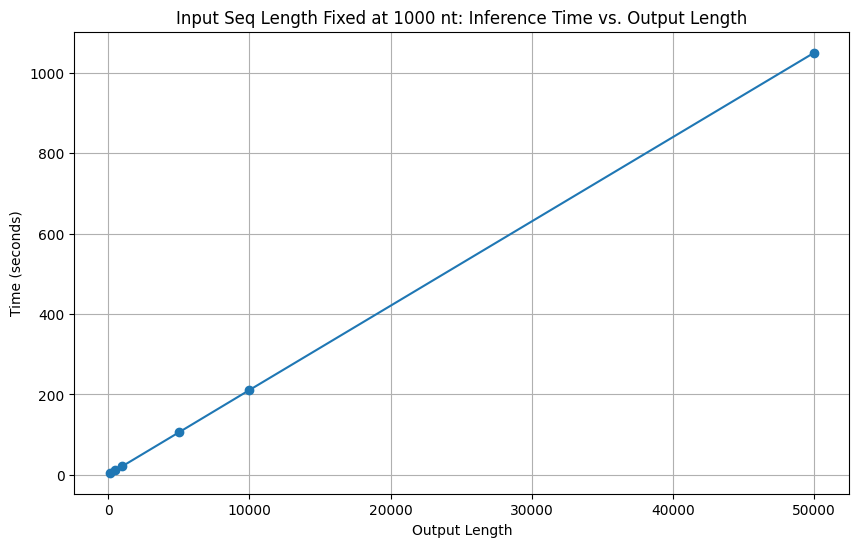

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(output_lengths, times, marker='o')
plt.title('Input Seq Length Fixed at 1000 nt: Inference Time vs. Output Length')
plt.xlabel('Output Length')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

In [12]:
test_prompt = "AACGTGCACTGAC"
generated_sequence, activations = run_inference(test_prompt, 5)

Initializing inference params...


In [15]:
print(f"{test_prompt}\n{generated_sequence}")

AACGTGCACTGAC
AACGTGCACTGACCGAAT


In [16]:
# for layer, activation in activations.items():
#    print(f"Layer: {layer}, Activation shape: {activation.shape}")

## Datasets

In [17]:
def load_datasets():
    with open('salmonella_cb_dataset_10.json', 'r') as f:
        cb_data = json.load(f)
    
    with open('salmonella_retain_dataset_10.json', 'r') as f:
        retain_data = json.load(f)
    
    with open('salmonella_test_dataset_10.json', 'r') as f:
        test_data = json.load(f)
    
    return cb_data, retain_data, test_data

cb_data, retain_data, test_data = load_datasets()
print(f"Datasets loaded. CB: {len(cb_data)}, Retain: {len(retain_data)}, Test: {len(test_data)}")

Datasets loaded. CB: 10, Retain: 10, Test: 10


In [18]:
unique_keys = {key for item in cb_data if isinstance(item, dict) for key in item.keys()}
print(unique_keys)

{'16S_strain_taxonomy', 'sequence_completion', 'plasmid_id', 'sequence_prompt', 'species_prefix'}


In [19]:
cb_sample = random.choice(cb_data)
cb_prompt = cb_sample.get('sequence_prompt', cb_sample.get('prompt', ''))
cb_completion = cb_sample.get('sequence_completion', cb_sample.get('completion', ''))

In [20]:
len(cb_prompt), len(cb_completion)

(74203, 21325)